In [10]:
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import functools

In [147]:
def read_file(fn):
    HFok, CCSDok, CCSDamplok, CCSDstr, MP2str, HFstr = detail_read_file(fn)

    if not (HFok and CCSDok):
        return None
    
    return CCSDstr, MP2str, HFstr

@functools.lru_cache(maxsize=10000)
def detail_read_file(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    HFok = len([_ for _ in lines if 'THE SCF ITERATION HAS CONVERGED!' in _]) > 0
    CCSDok = len([_ for _ in lines if 'CCSD iteration has converged' in _]) > 0
    CCSDamplok = len([_ for _ in lines if 'Warning: large CCSD amplitude found' in _]) == 0

    try:
        CCSDstr = [_ for _ in lines if 'Total CCSD energy [au]' in _][0].strip().split()[-1].replace('-', '').replace('.', '') + "000"
        MP2str = [_ for _ in lines if 'MP2 energy [au]:' in _][0].strip().split()[-1].replace('-', '').replace('.', '') + "000"
        HFstr = [_ for _ in lines if '***FINAL HARTREE-FOCK ENERGY' in _][0].strip().split()[-2].replace('-', '').replace('.', '')[:-1]
    except:
        #print ('Problem parsing %s' % fn)
        return False, False, False, 0, 0, 0
    
    return HFok, CCSDok, CCSDamplok, CCSDstr, MP2str, HFstr

In [120]:
detail_read_file('data/run-1.4-0.6.log')

(True,
 True,
 True,
 '110621330978672000',
 '110657606867800000',
 '110182882770248497')

In [121]:
fns = glob.glob('data/run-*.log')
ds = []
qs = []
for fn in fns:
    dist = float(fn.split('-')[1])
    qa = float(fn.split('-')[2][:-4])
    ds.append(dist)
    qs.append(qa)
ds = sorted(set(ds))
qs = sorted(set(qs))
read_file('data/run-3.0-1.0.log')

('112618896106101000', '112559469249881000', '112281250416876474')

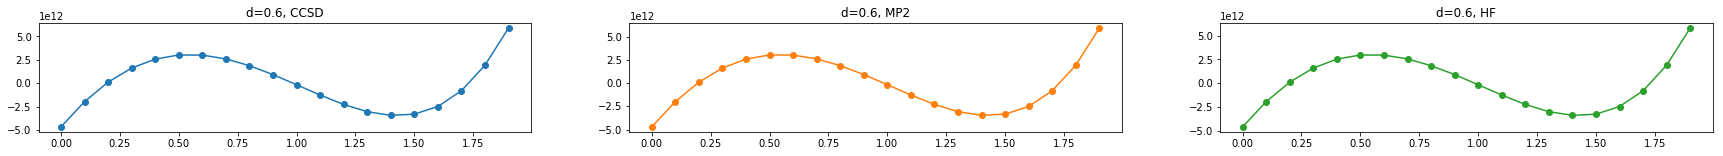

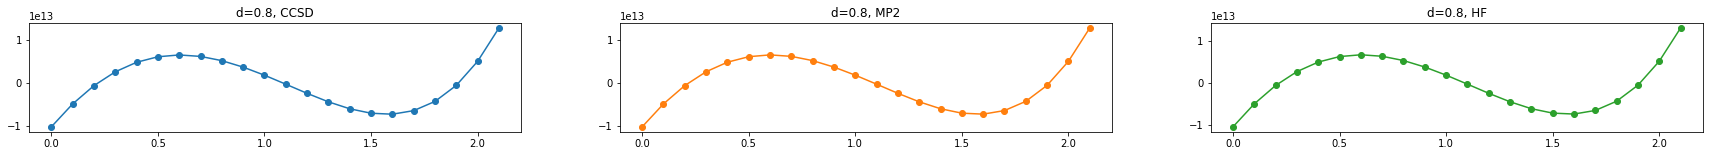

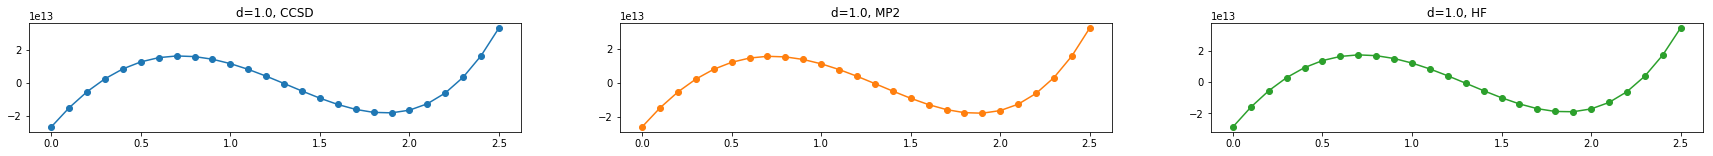

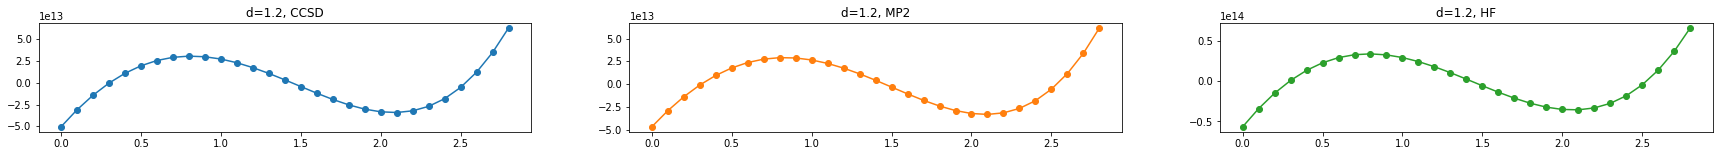

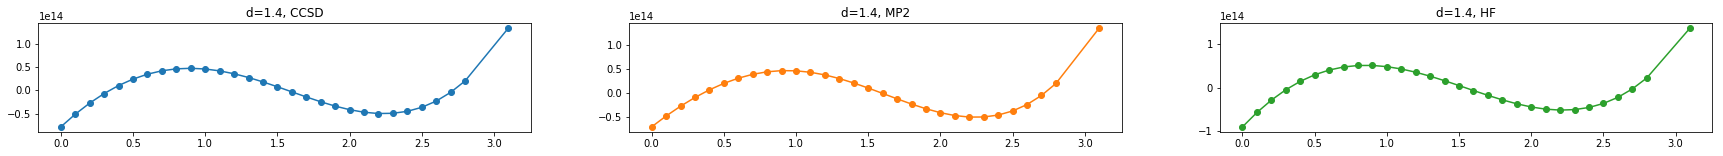

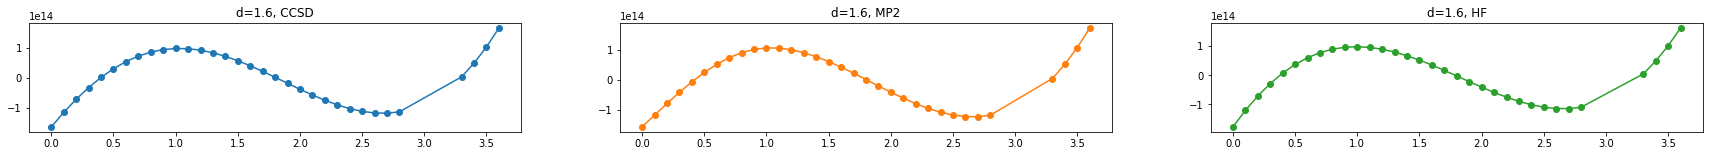

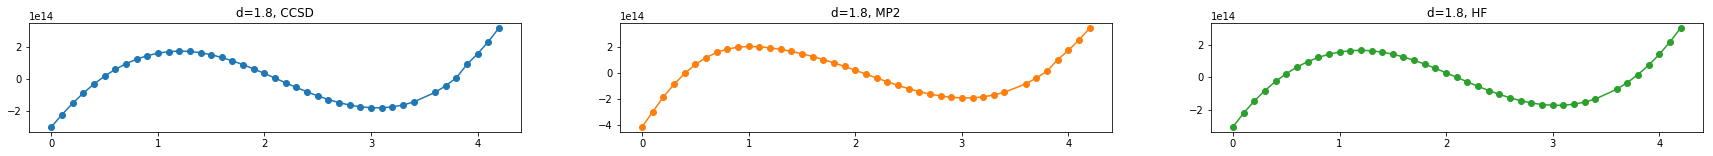

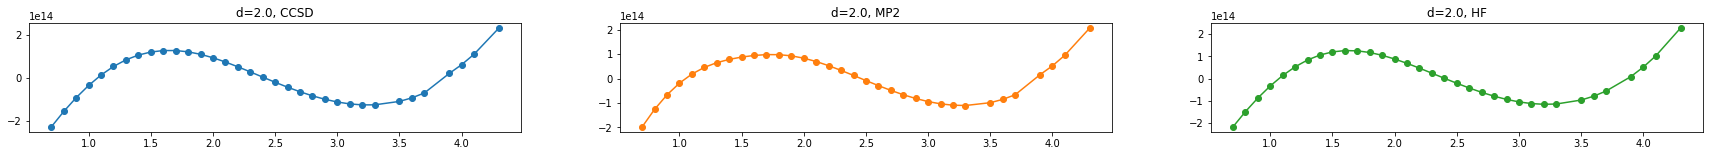

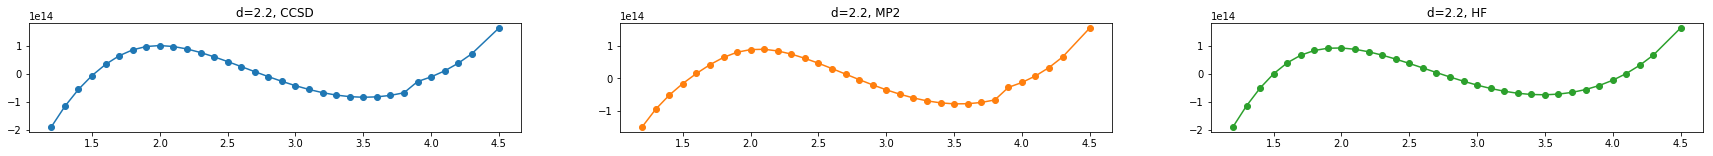

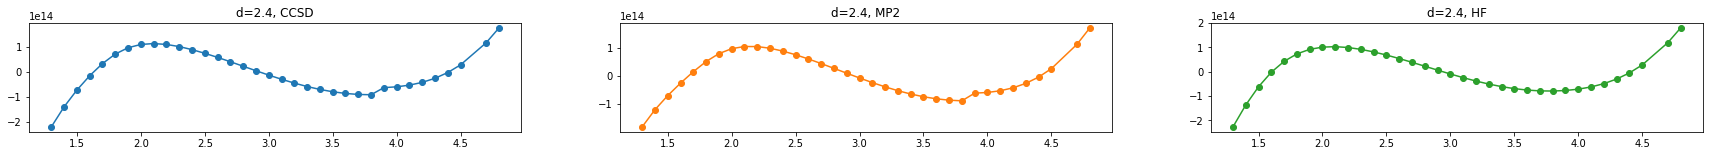

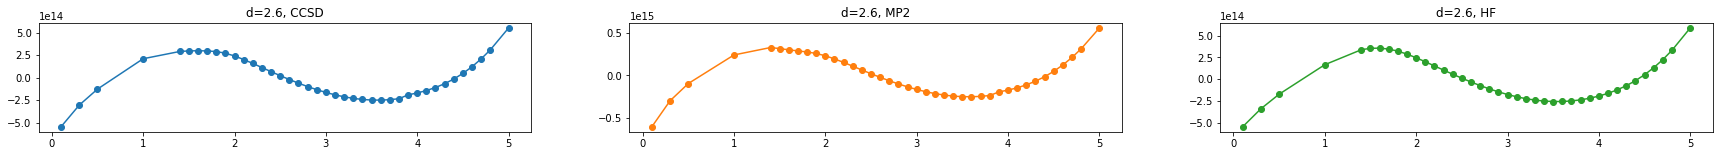

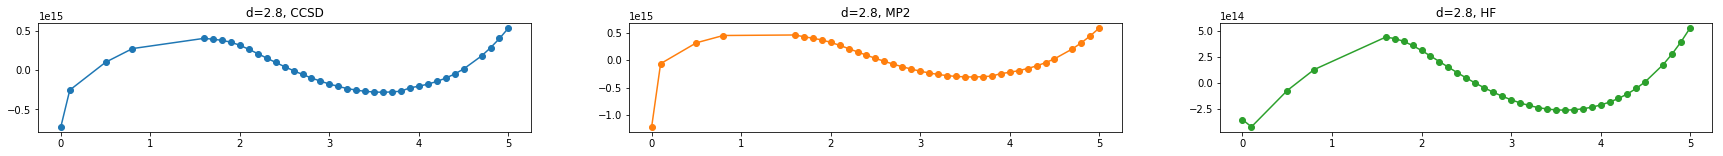

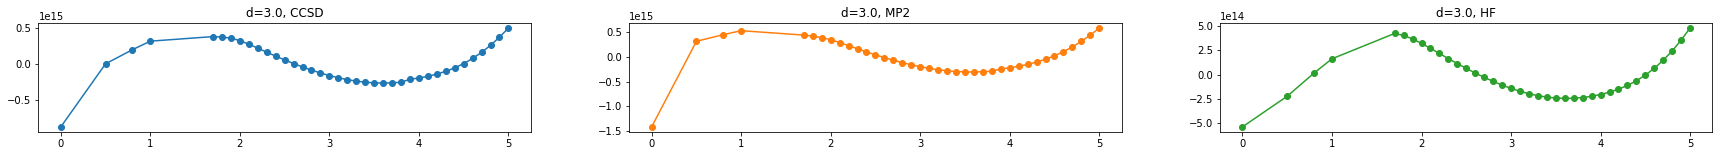

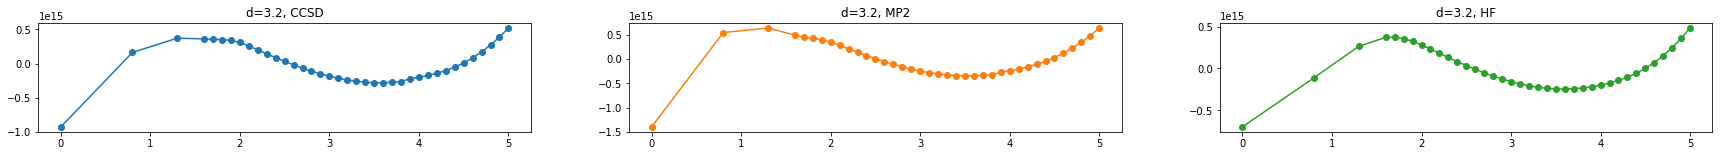

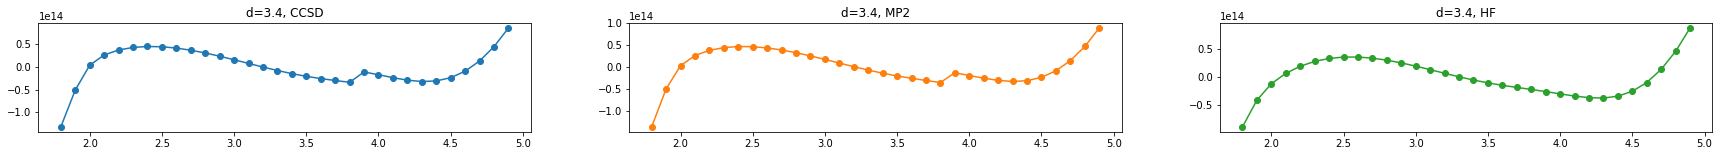

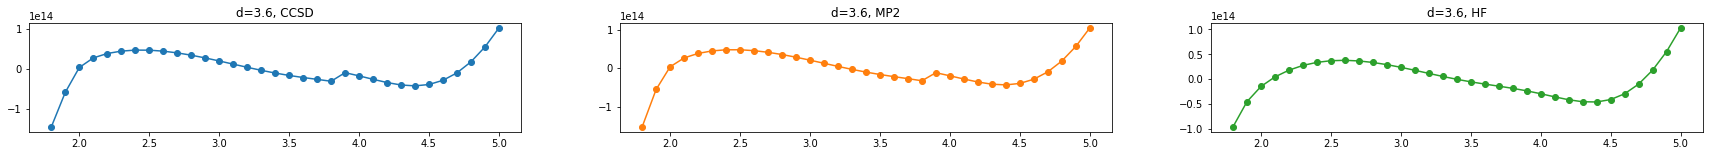

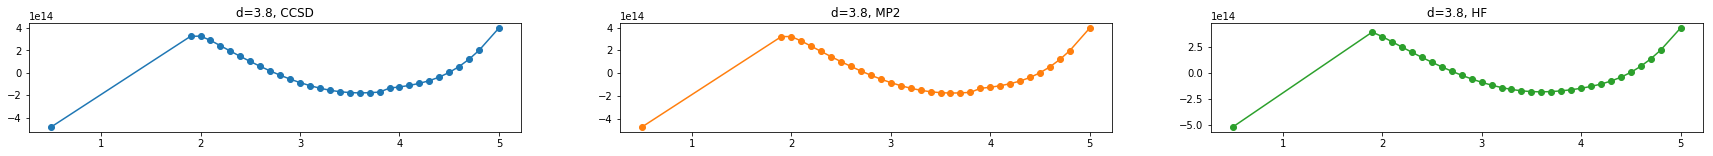

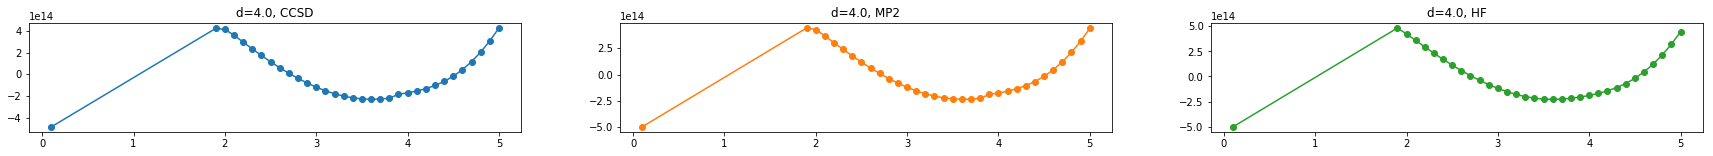

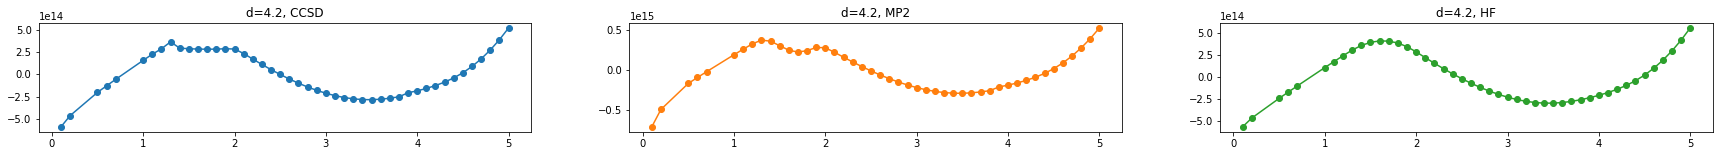

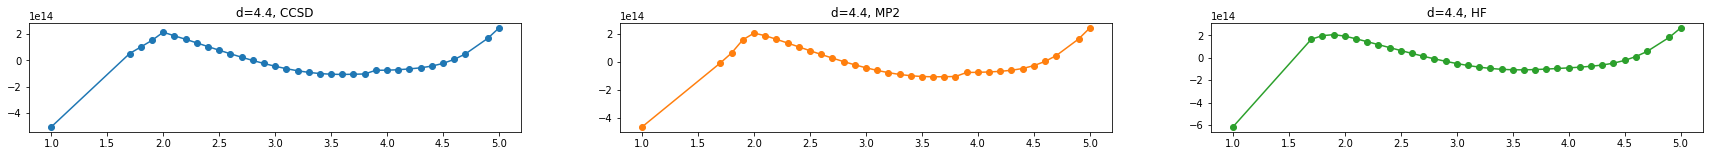

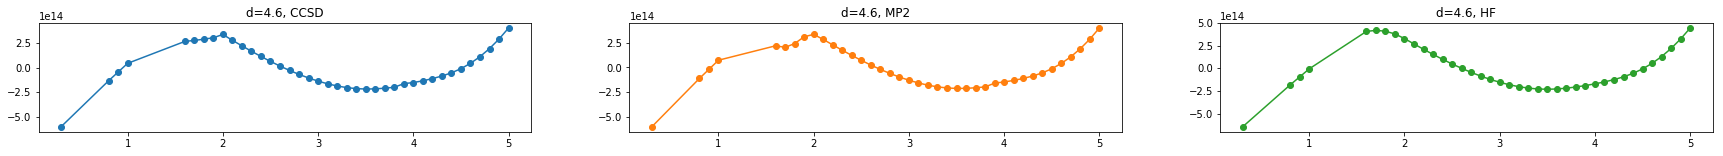

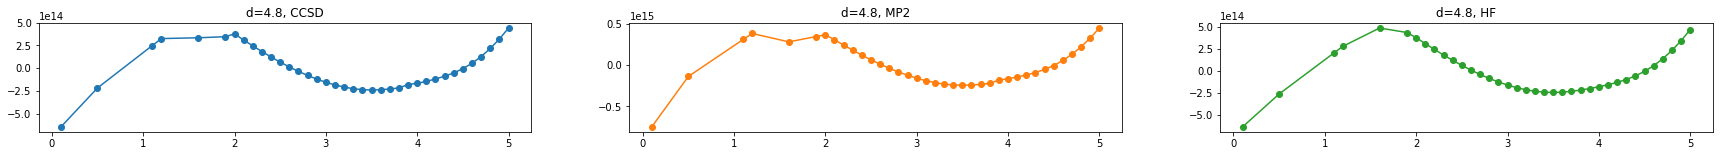

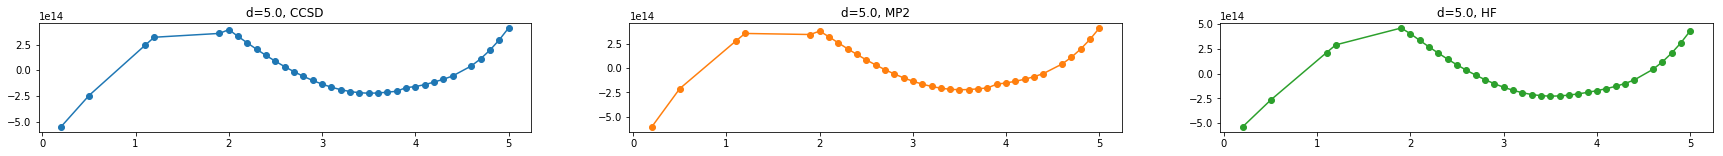

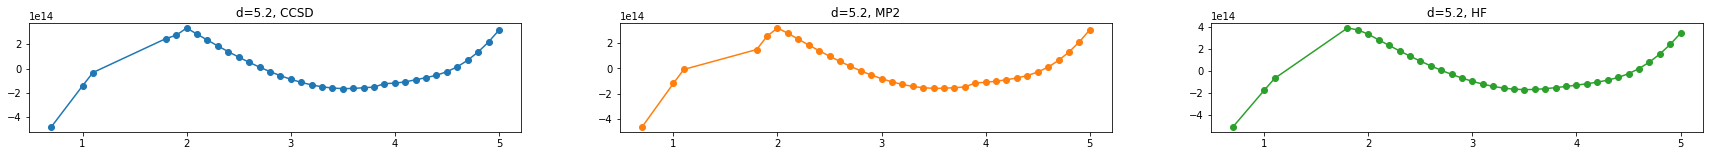

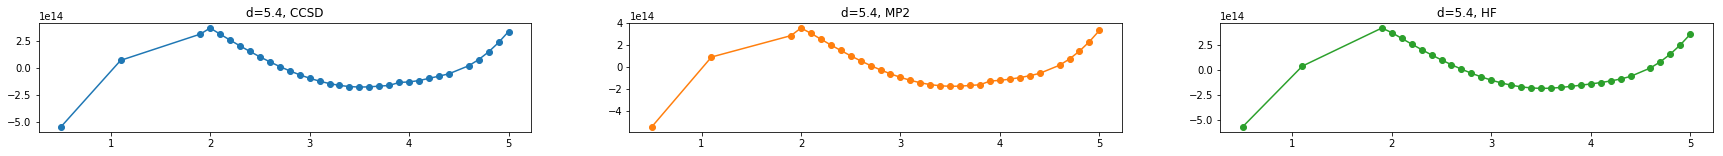

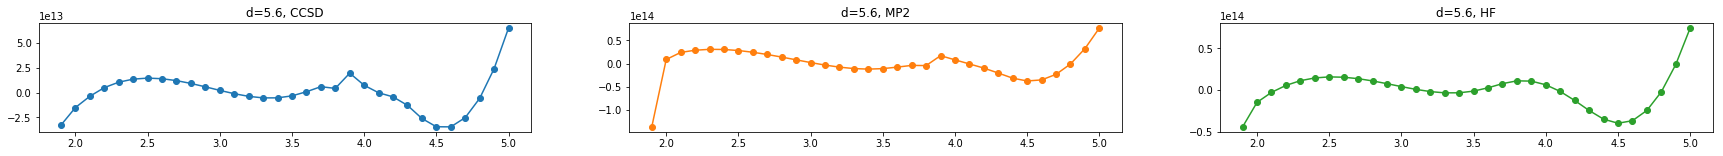

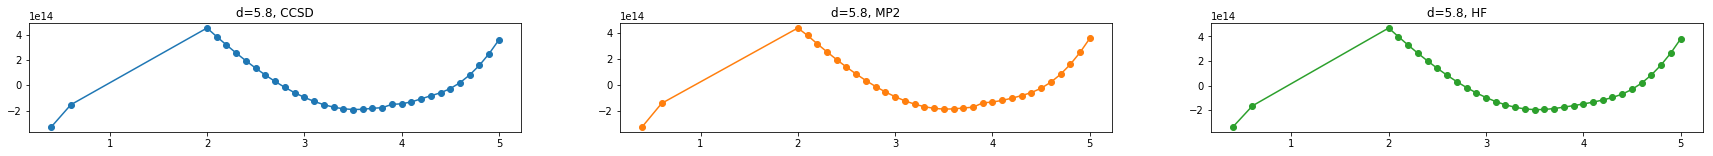

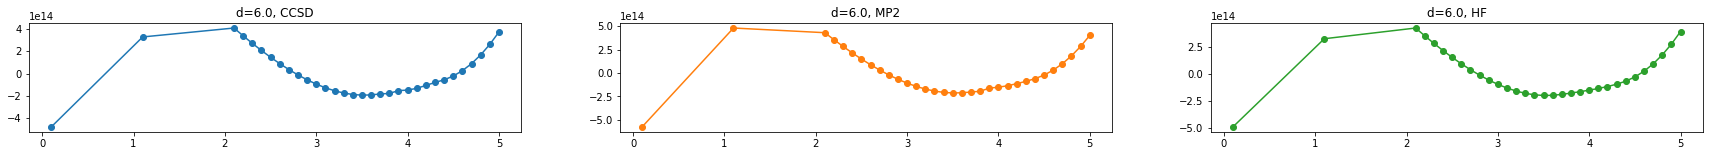

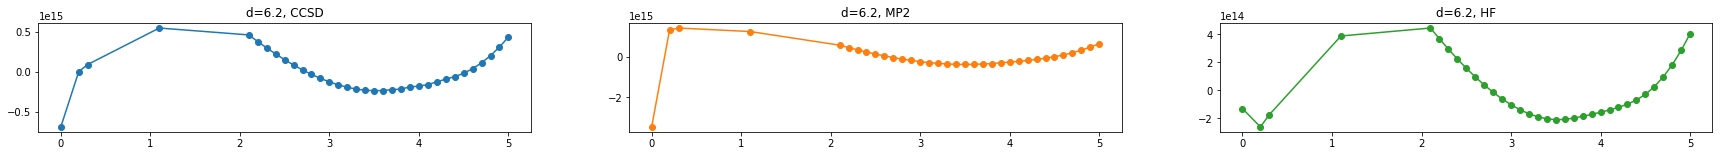

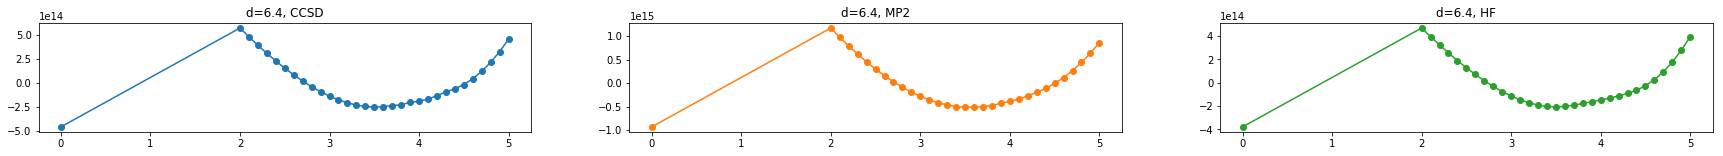

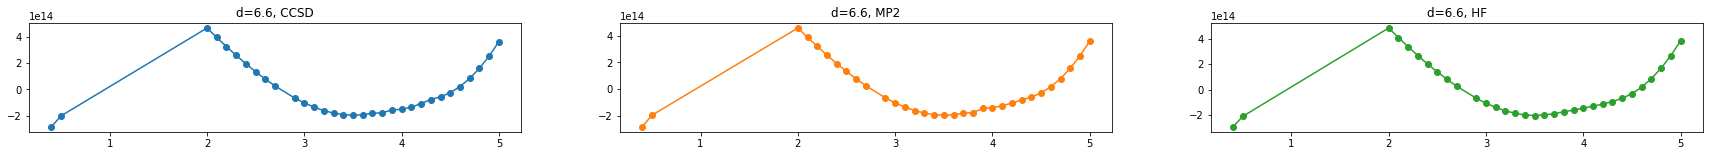

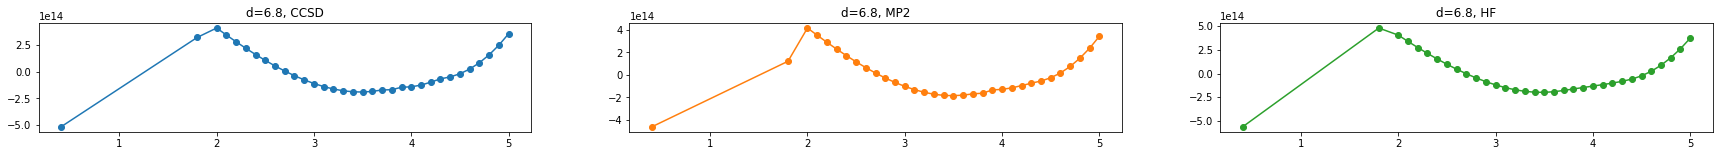

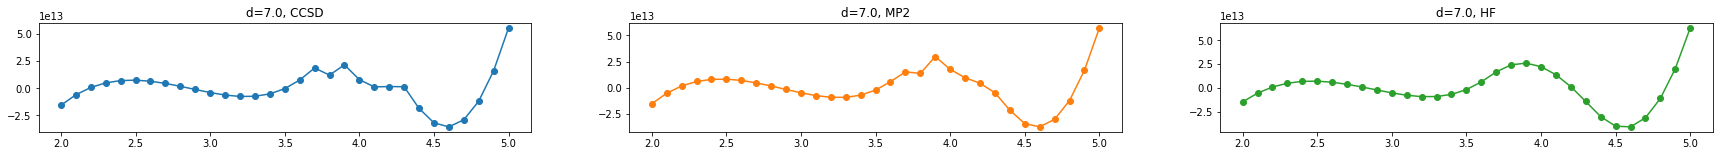

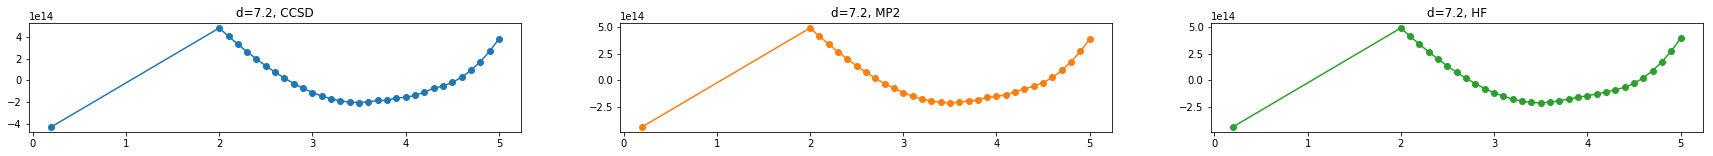

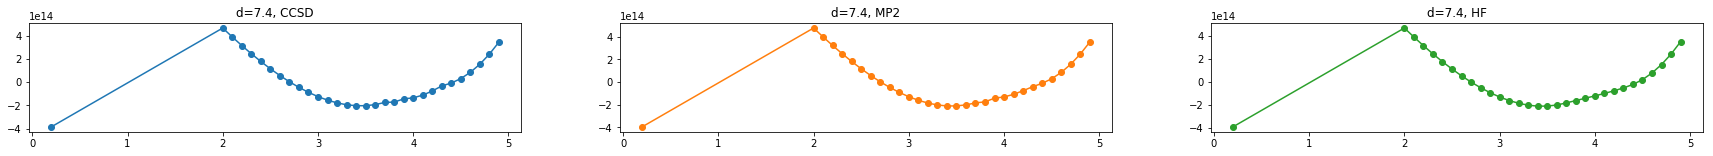

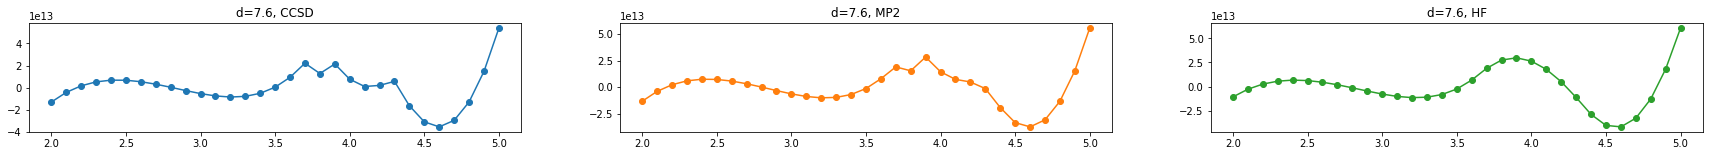

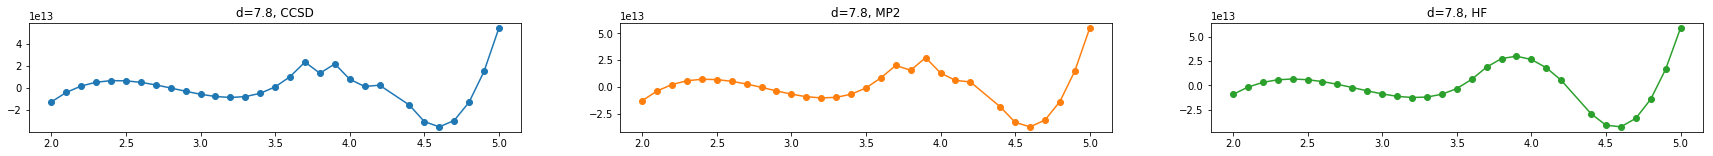

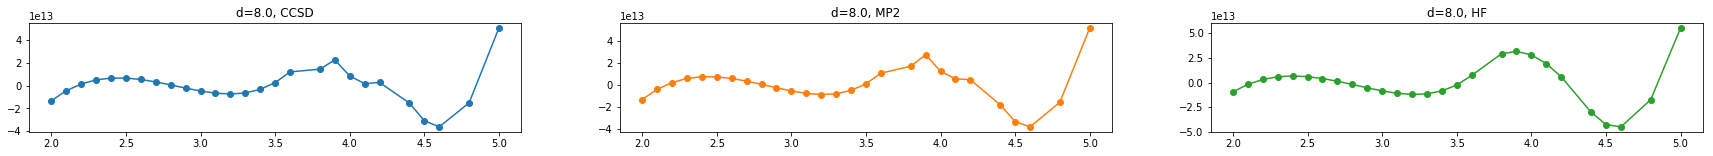

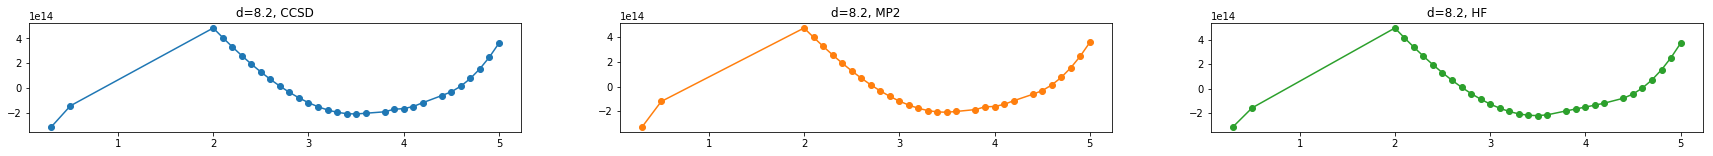

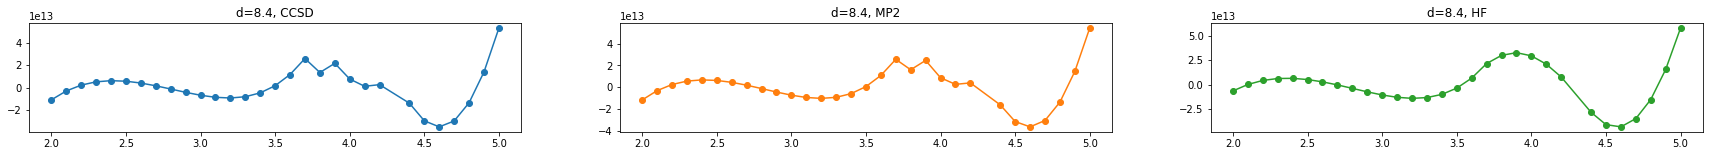

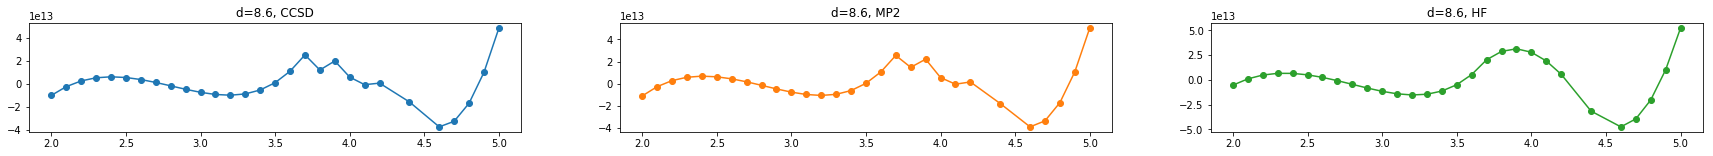

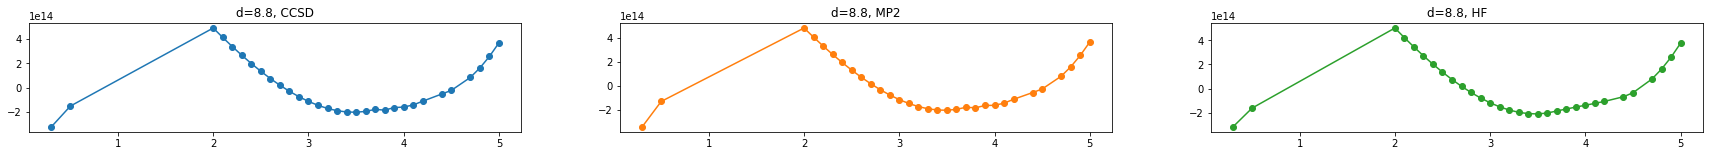

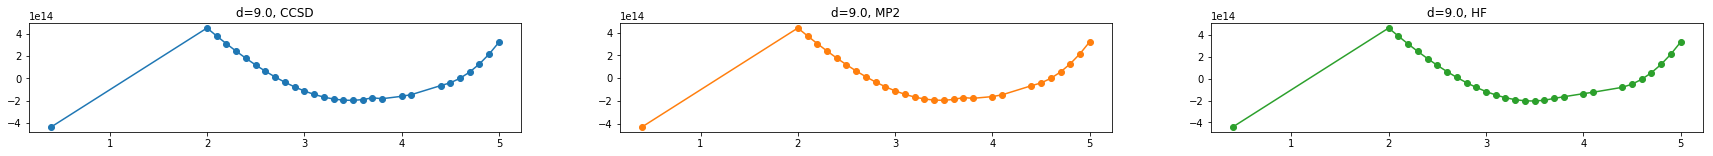

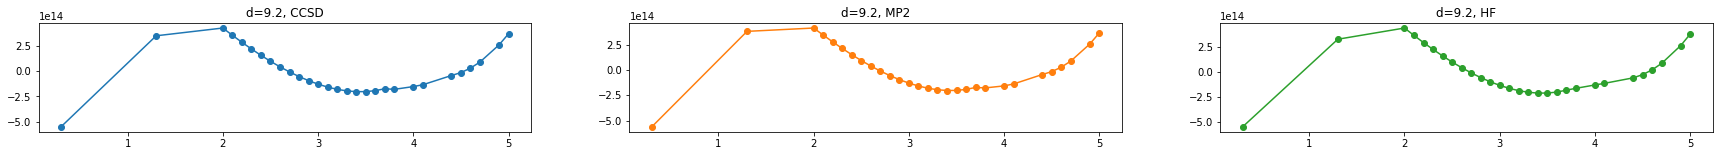

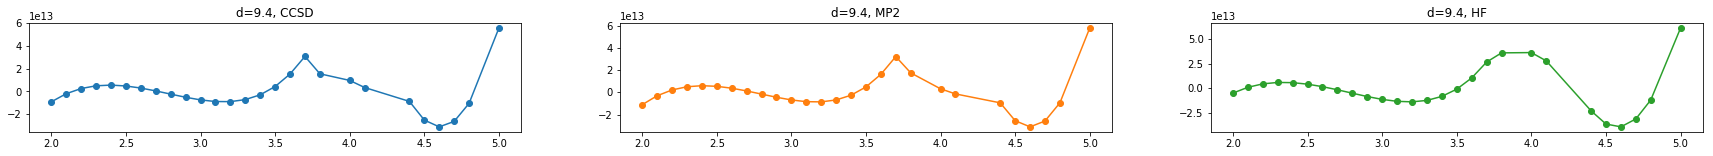

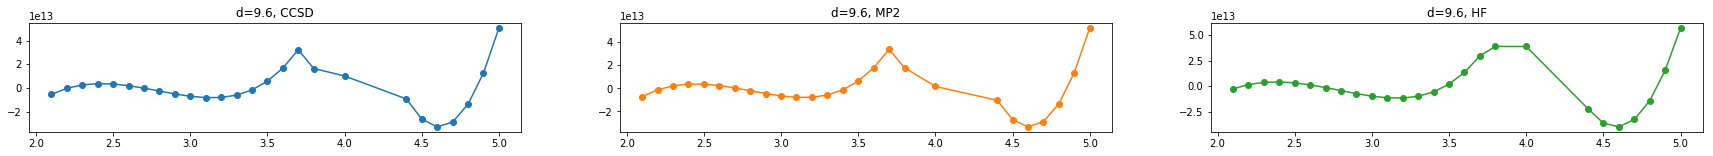

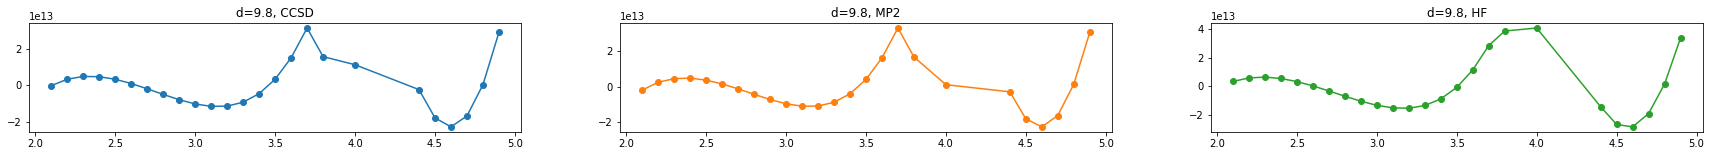

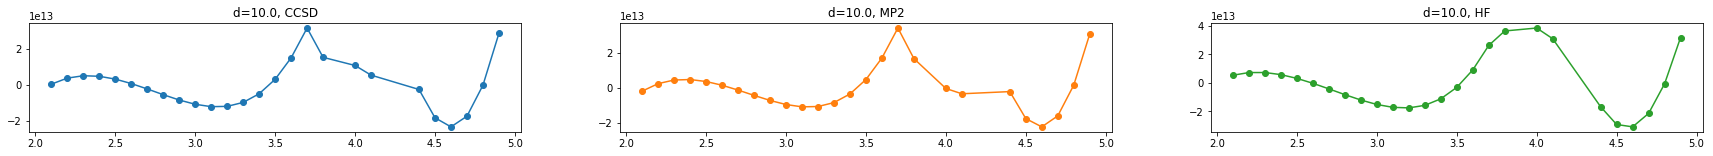

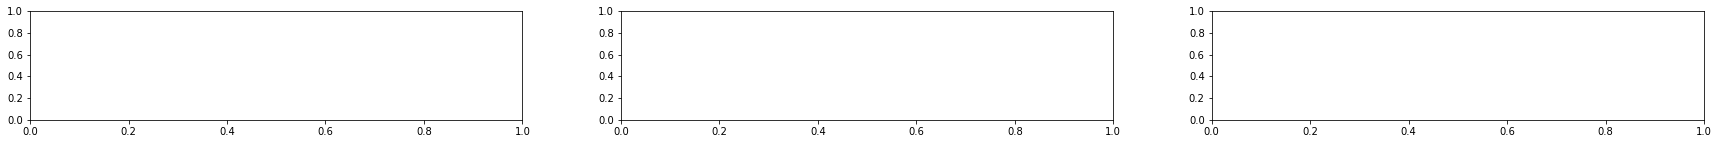

In [149]:
f, axs = plt.subplots(1,3, figsize=(30, 2))
alternative = 'scicore'
for d in ds:
    found = False
    for midx, method in enumerate('CCSD MP2 HF'.split()):
        ts = []
        tq = []
        for fn in sorted(glob.glob('data/run-%1.1f-*.log' % d)):
            status = read_file(fn)
            if status is not None:
                ts.append(int(status[midx]))
                tq.append(float(fn.split('-')[2][:-4]))
        if len(ts) <= 1:
            continue
        found = True
        
        # fit baseline and remove that one
        xs = np.array(tq)
        ys = np.array([-_ for _ in ts])
        if len(tq) > 3:
            poly = np.poly1d(np.polyfit(xs, ys, 2))
            ys -= poly(xs).astype(np.int)
        
        axs[midx].plot(xs, ys, 'o-', color='C%d' % midx)
        axs[midx].set_title('d=%s, %s' % (d, method))
        for fn in sorted(glob.glob('data/%s/run-%1.1f-*.log' % (alternative, d))):
            status = read_file(fn)
            if status is not None:
                yval = -int(status[midx])
                xval = float(fn.split('-')[2][:-4])
                axs[midx].scatter(xval, yval - poly(xval), color="red", zorder=100)
                print ('ALTERNATIVE')
    if not found:
        continue
    plt.show()
    f, axs = plt.subplots(1,3, figsize=(30, 2))

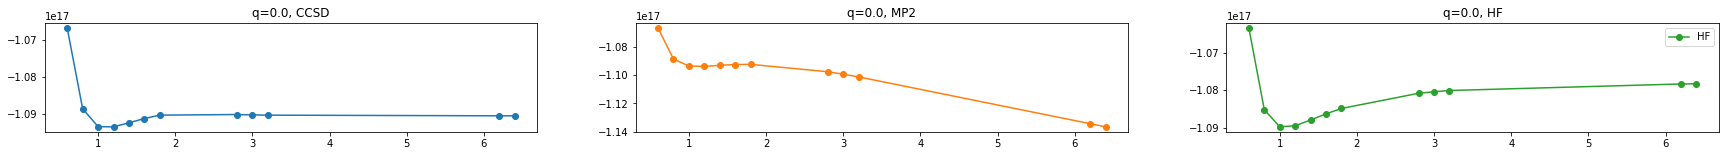

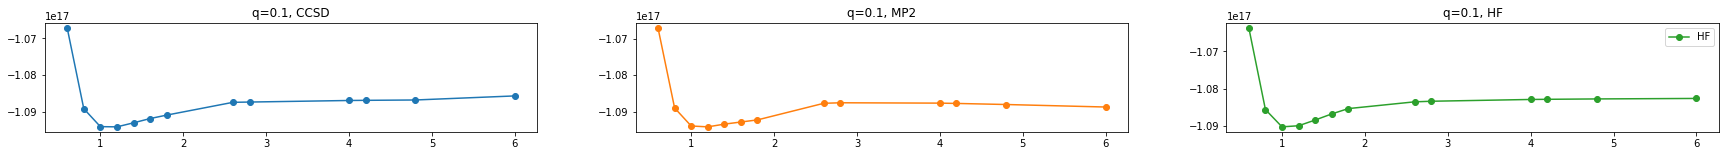

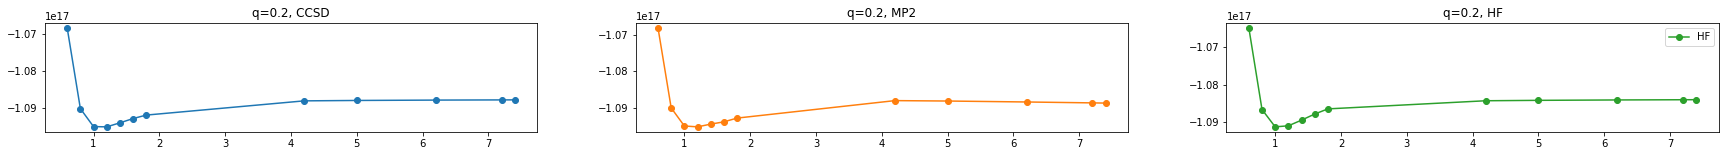

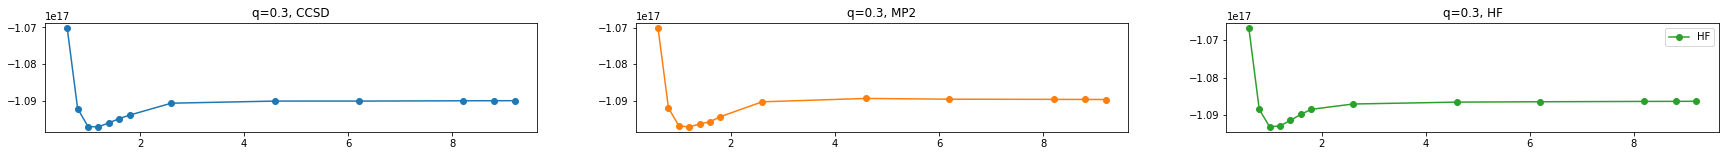

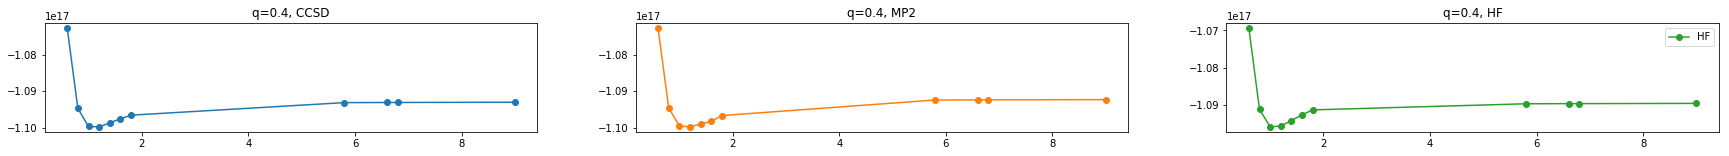

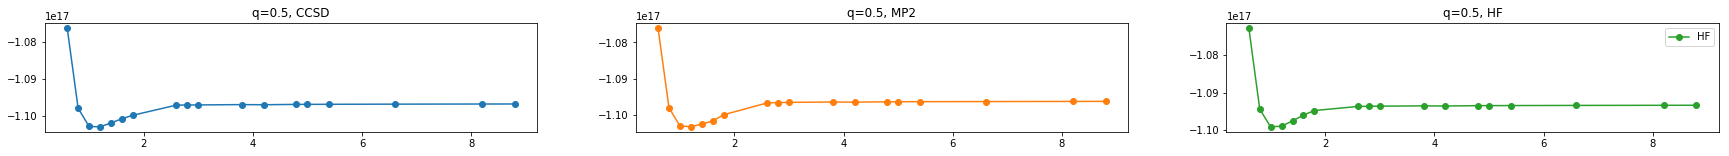

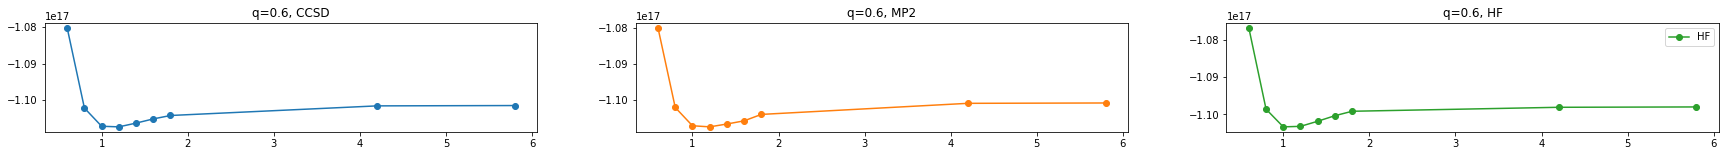

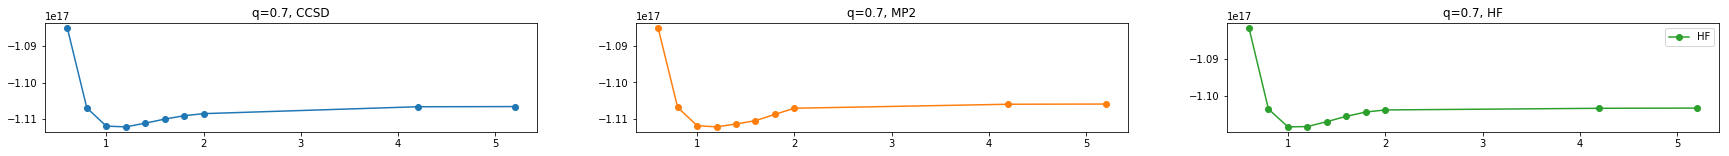

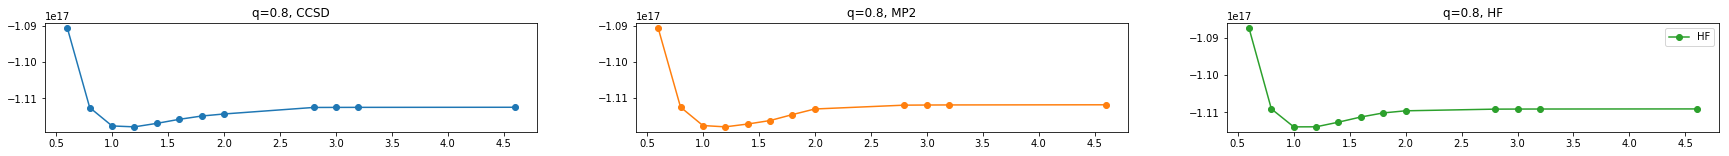

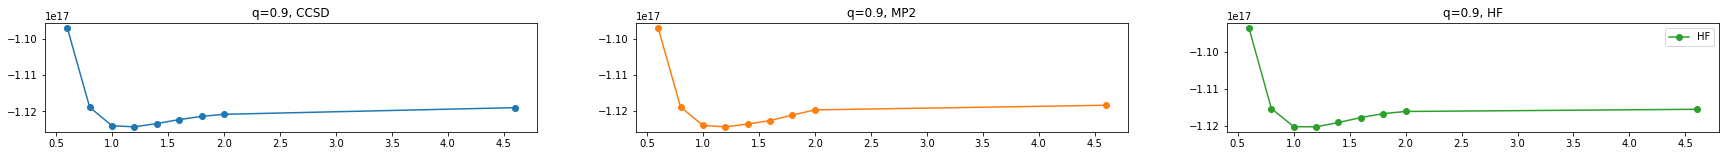

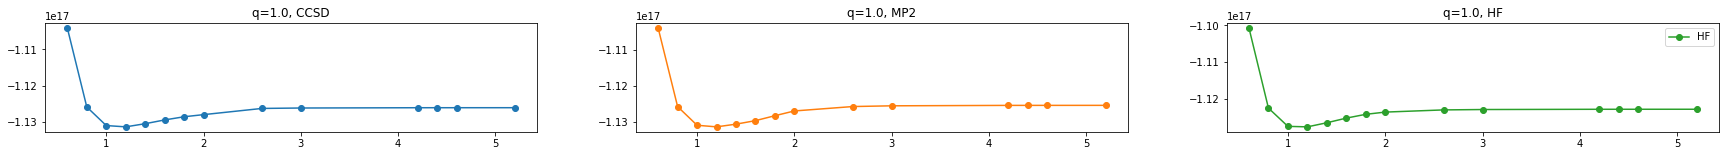

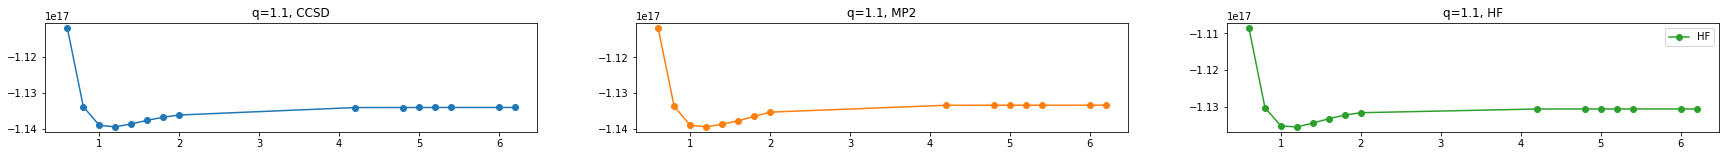

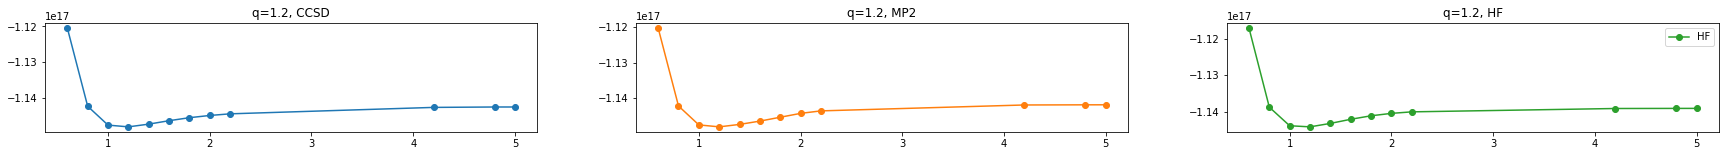

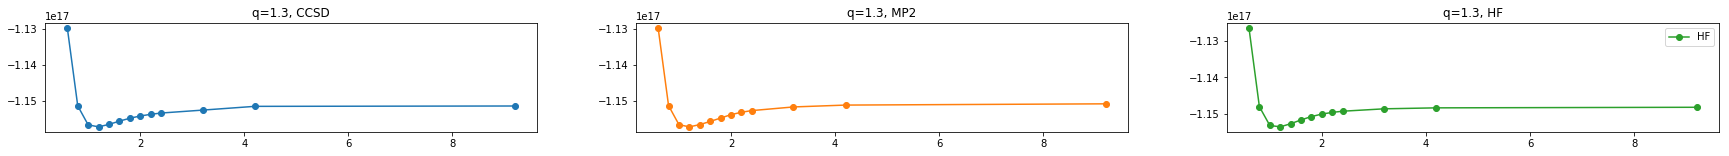

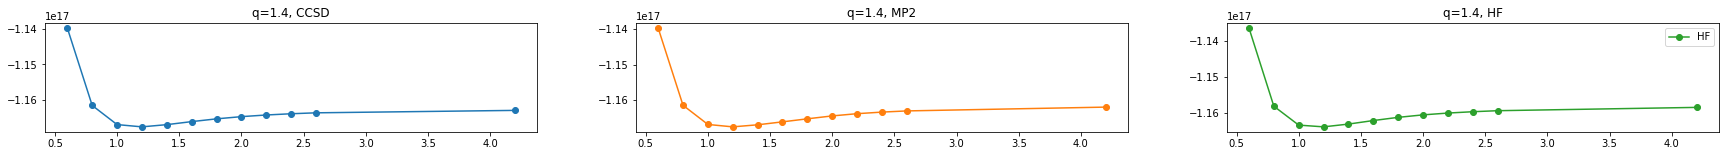

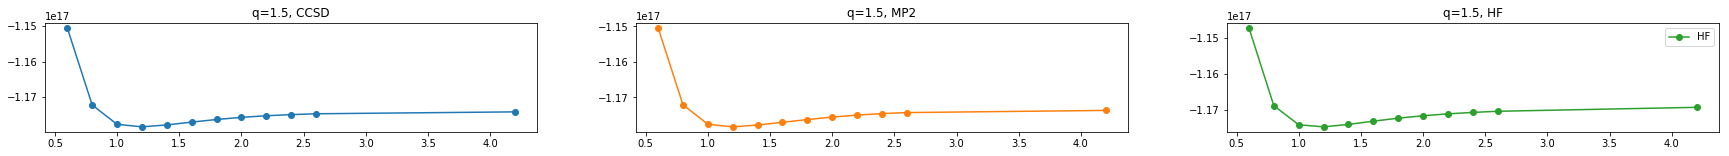

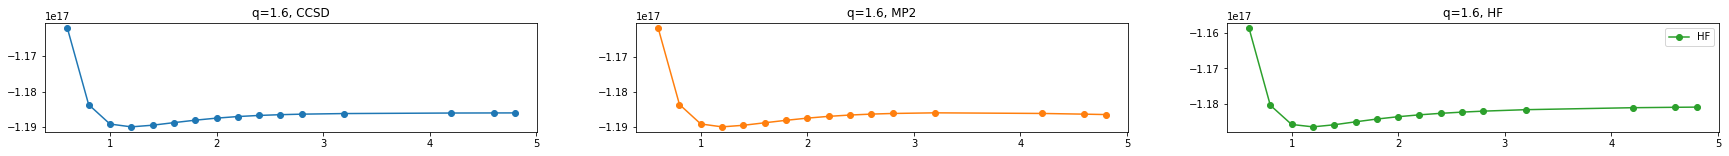

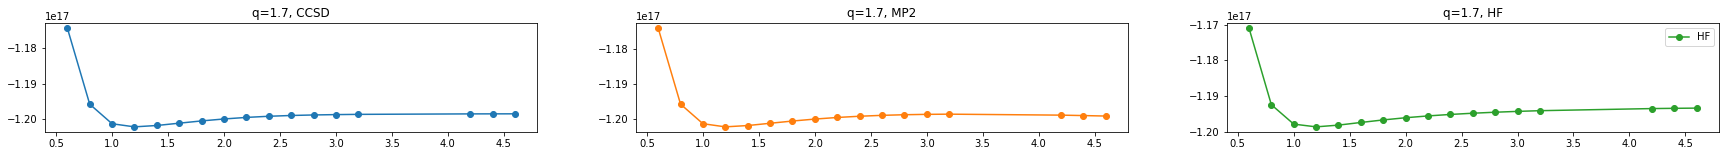

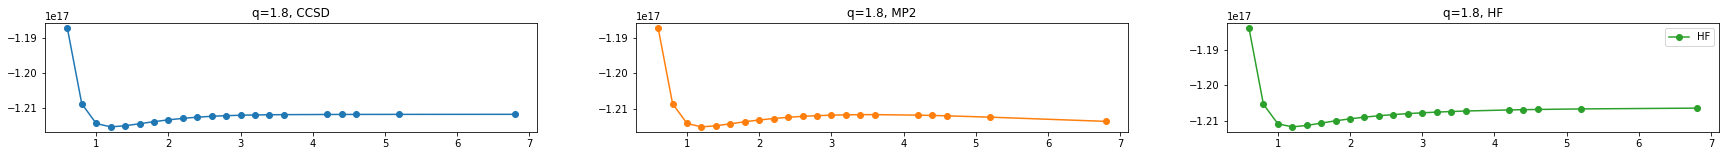

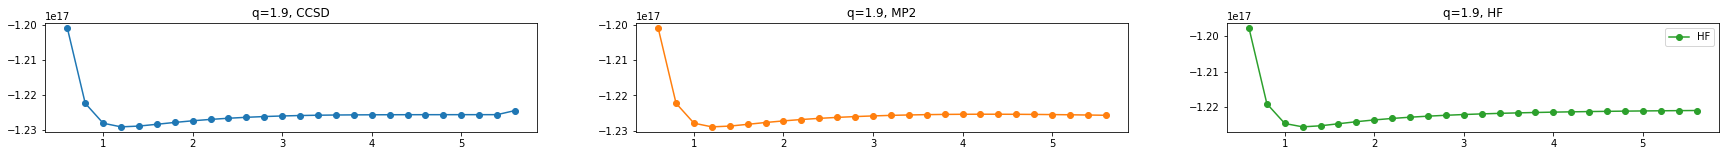

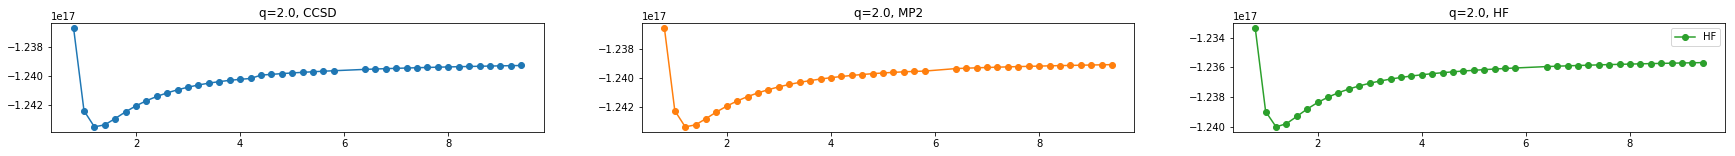

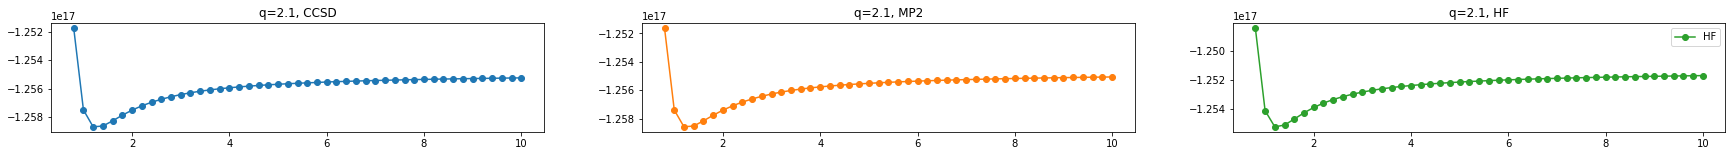

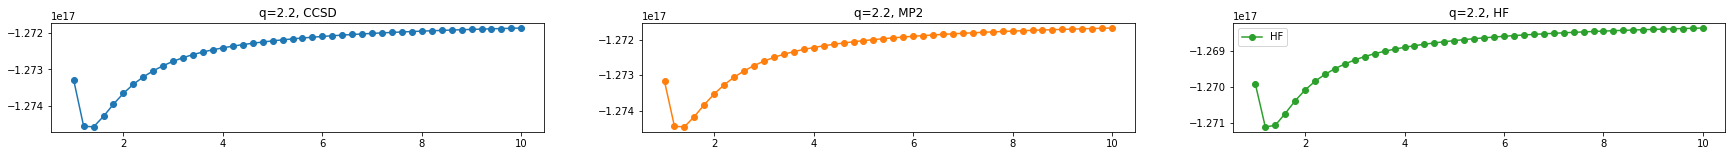

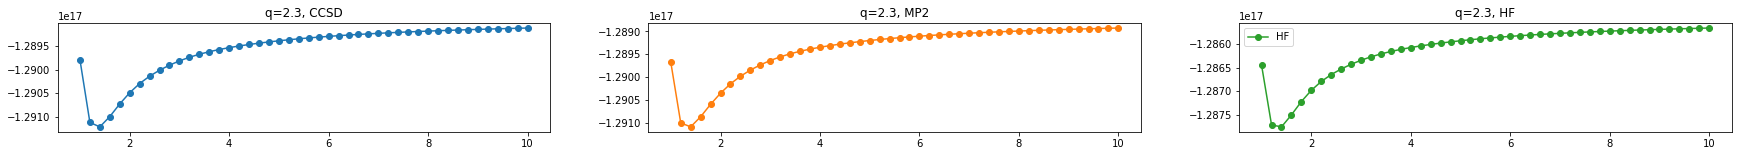

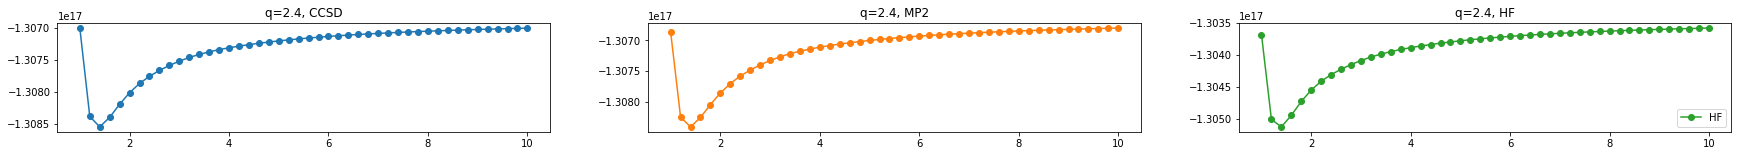

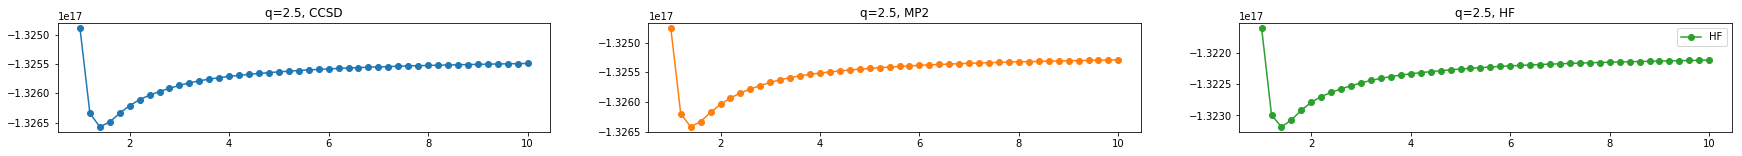

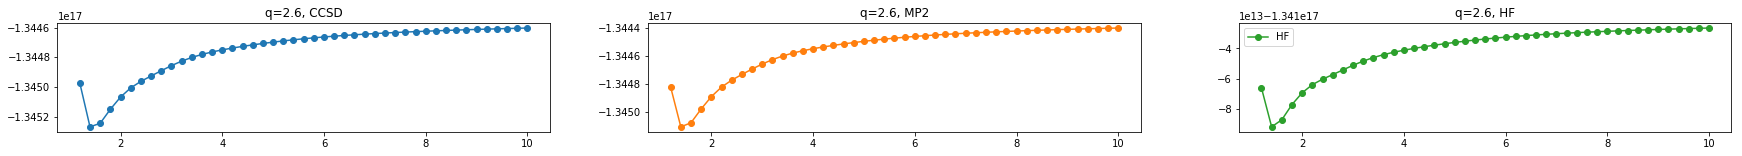

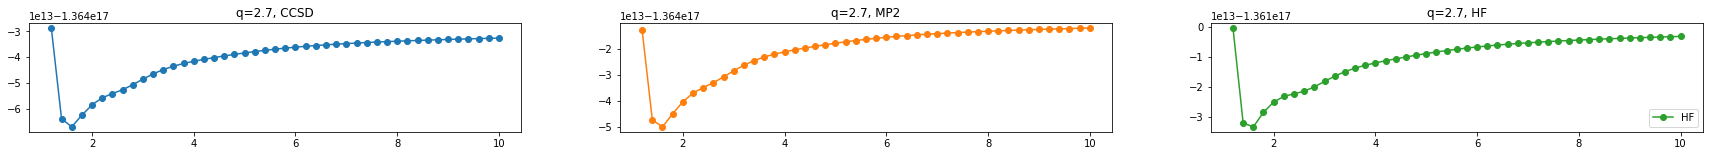

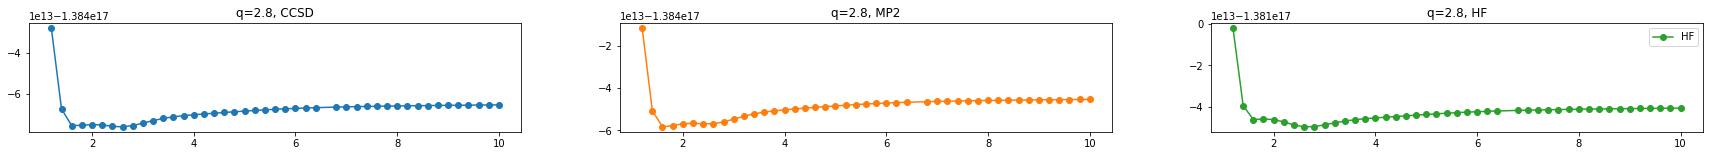

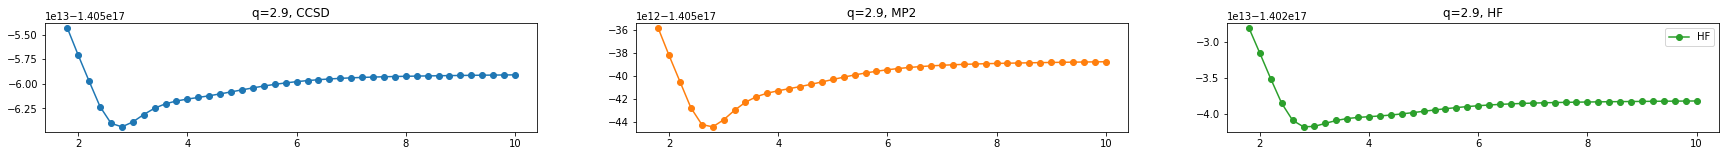

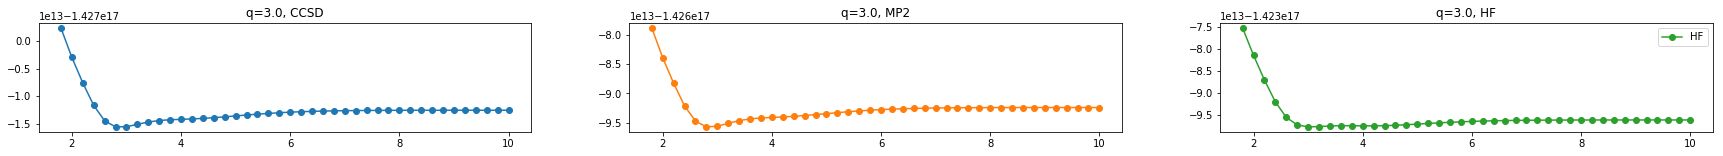

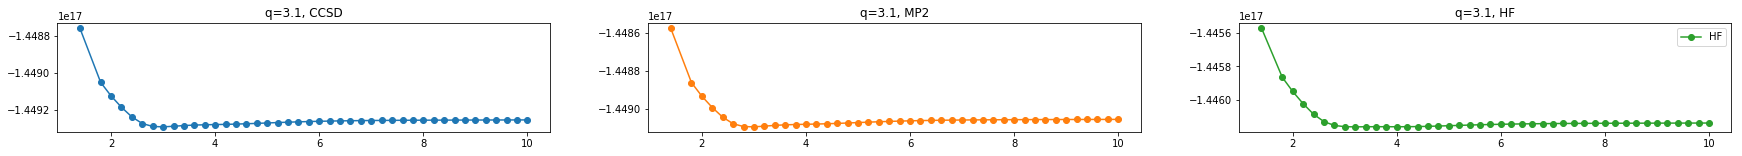

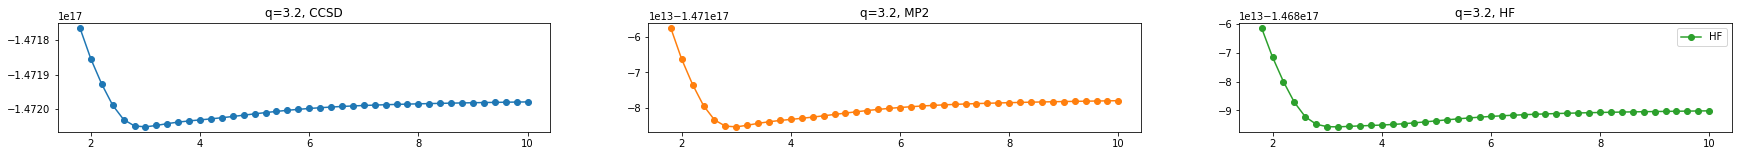

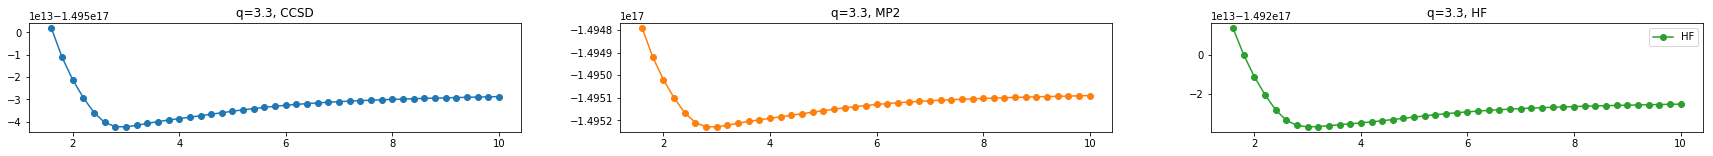

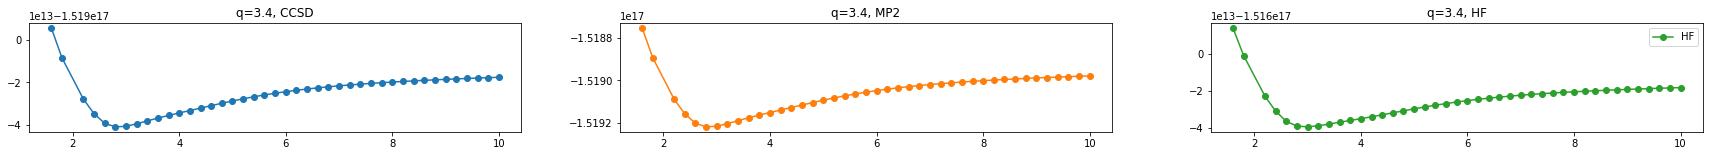

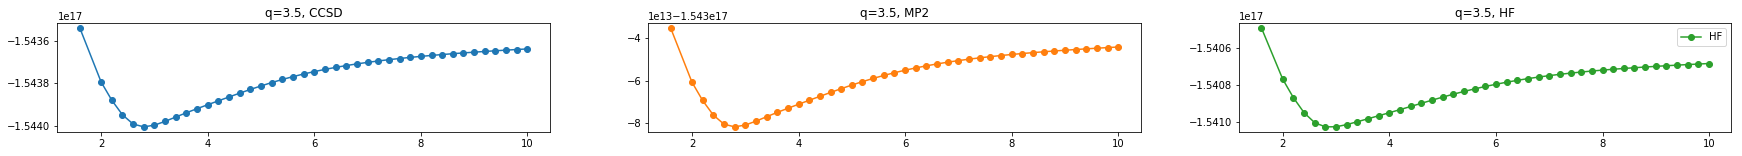

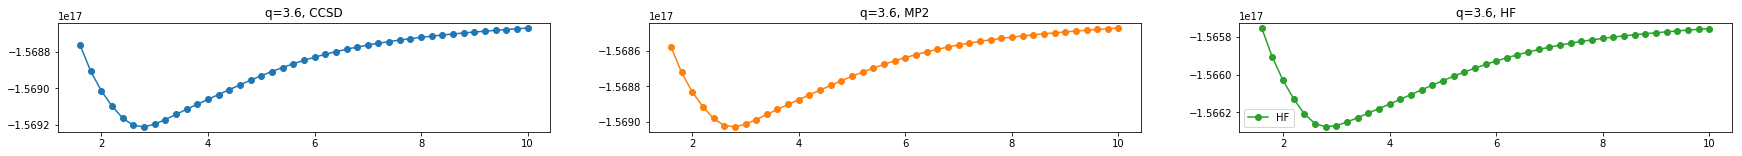

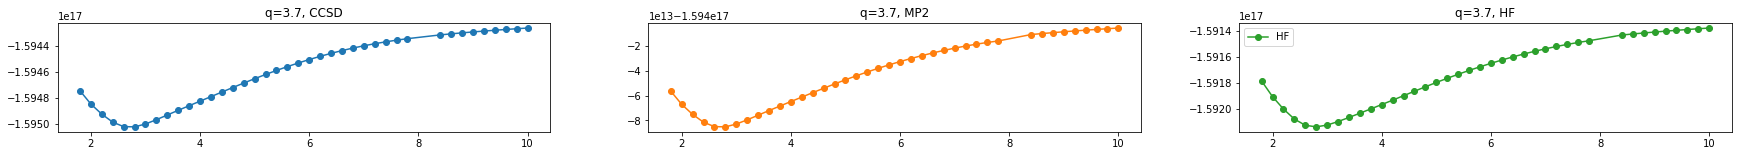

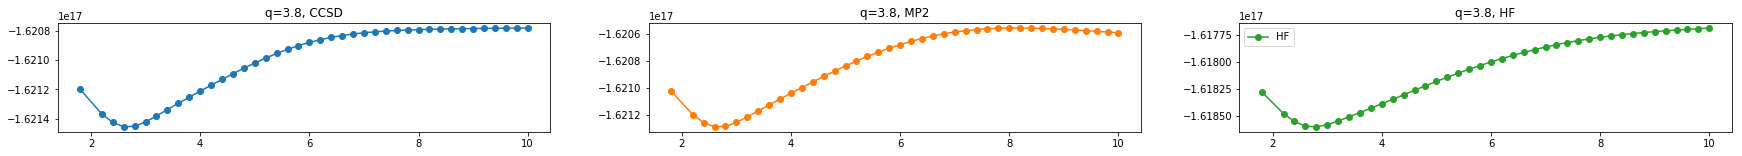

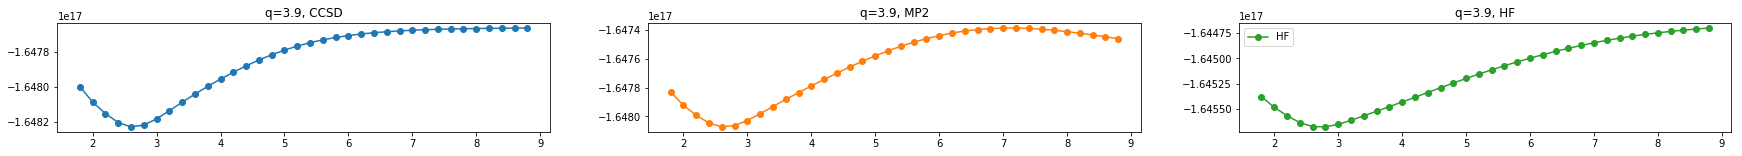

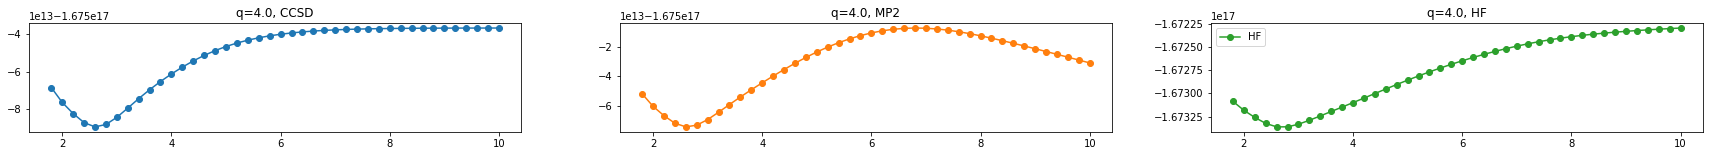

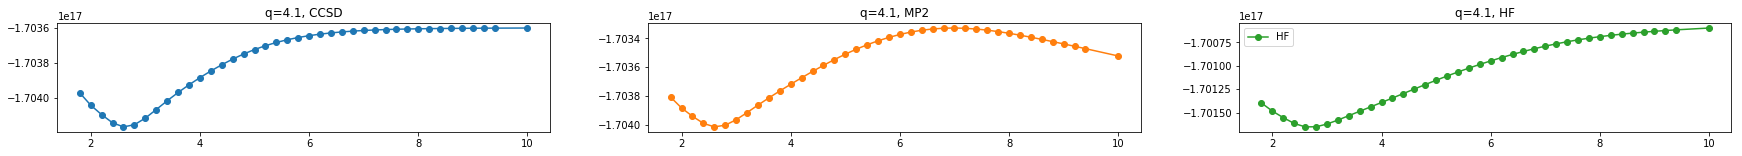

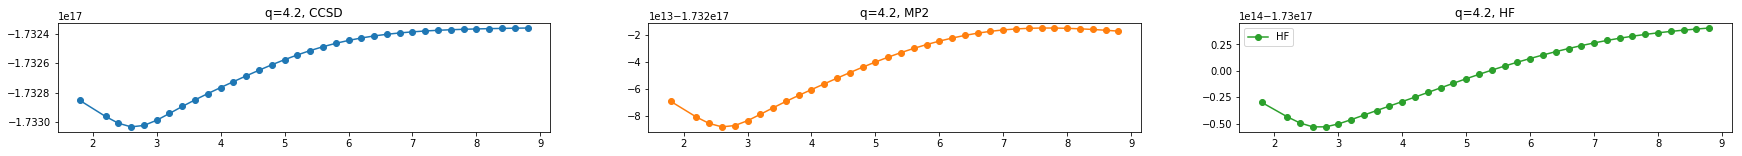

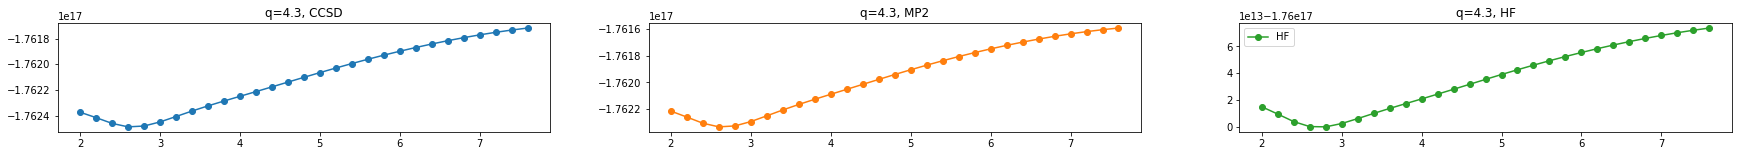

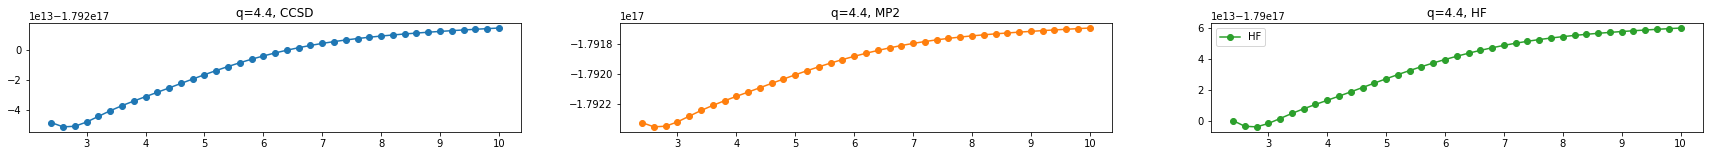

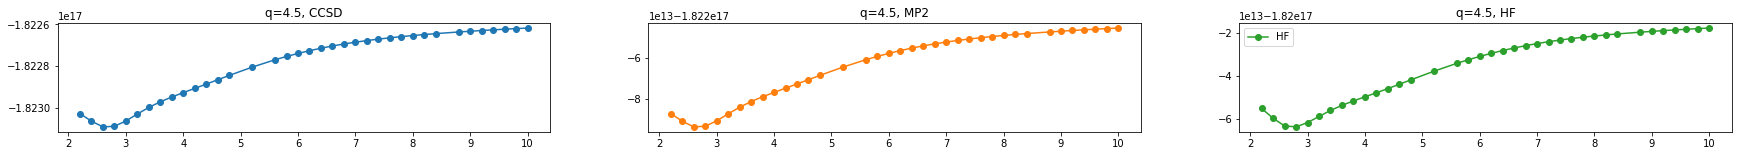

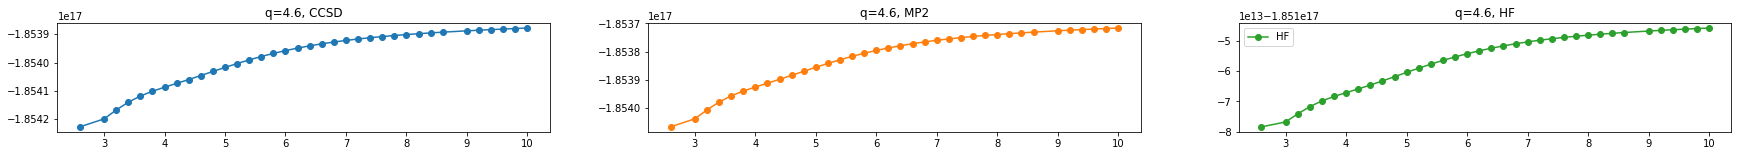

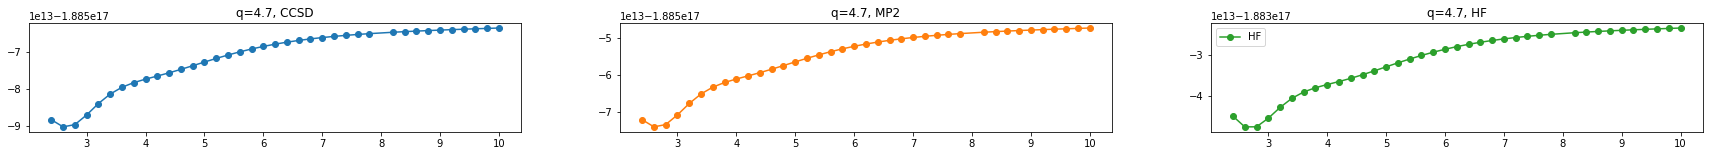

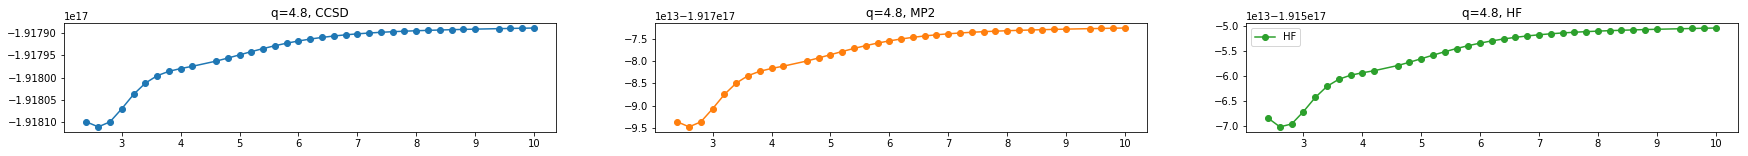

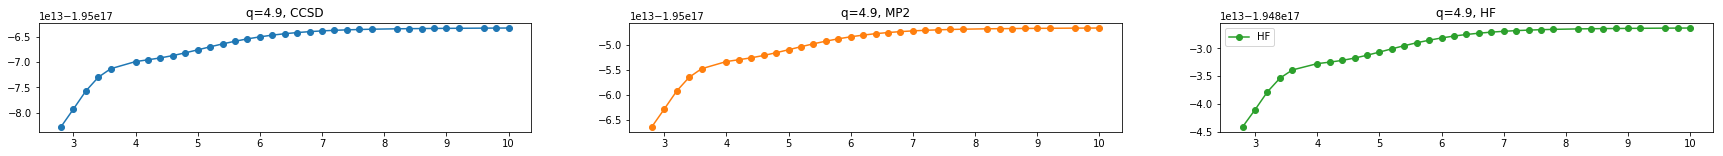

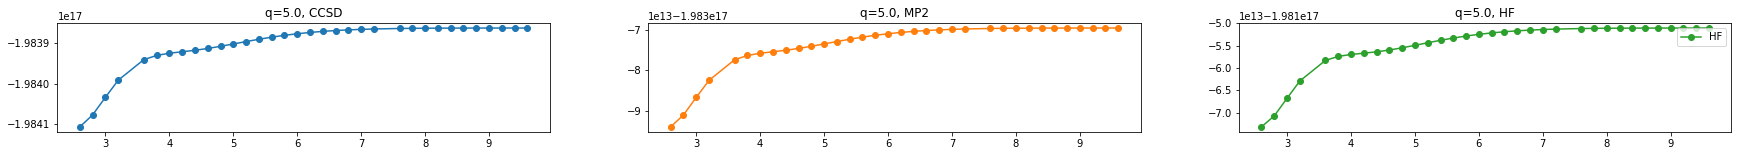

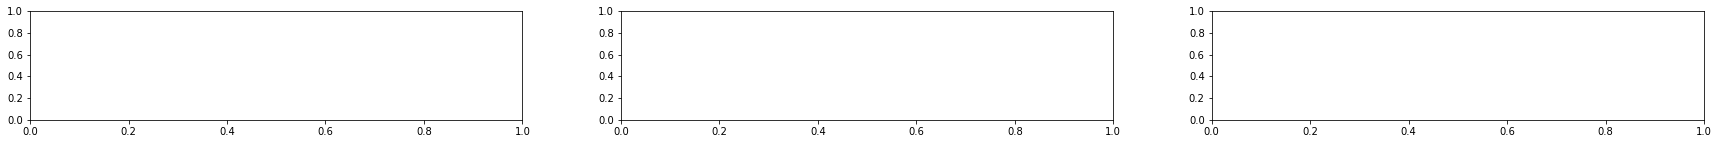

In [148]:
f, axs = plt.subplots(1,3, figsize=(30, 2))
alternative = 'scicore'
for q in qs:
    found = False
    for midx, method in enumerate('CCSD MP2 HF'.split()):
        ts = []
        tq = []
        for fn in sorted(glob.glob('data/run-*-%1.1f.log' % q)):
            status = read_file(fn)
            if status is not None:
                ts.append(int(status[midx]))
                tq.append(float(fn.split('-')[1]))
        if len(ts) <= 1:
            continue
        found = True
        ts = np.array(ts)
        ts = ts[np.argsort(tq)]
        tq = sorted(tq)
        axs[midx].plot(tq, [-_ for _ in ts], 'o-', label=method, color='C%d' % midx)
        axs[midx].set_title('q=%s, %s' % (q, method))
        
        for fn in sorted(glob.glob('data/%s/run-*-%1.1f.log' % (alternative, q))):
            status = read_file(fn)
            if status is not None:
                yval = -int(status[midx])
                xval = float(fn.split('-')[1])
                axs[midx].scatter(xval, yval, color="red", zorder=100)
                print ('ALTERNATIVE')
    if not found:
        continue
    
    plt.legend()
    plt.show()
    f, axs = plt.subplots(1,3, figsize=(30, 2))

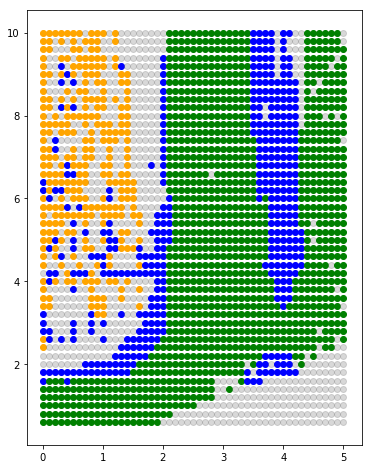

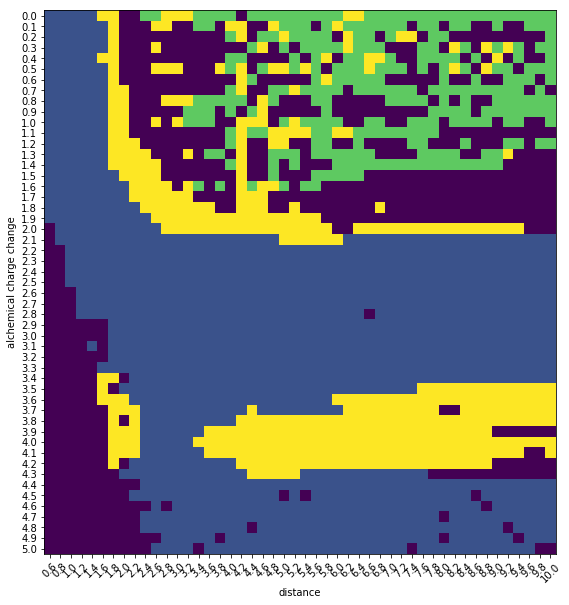

In [152]:
coverage = np.zeros((len(qs), len(ds)))
plt.figure(figsize=(6, 8))
results = []
for qidx, q in enumerate(qs):
    for didx, d in enumerate(ds):
        fn = 'data/run-%1.1f-%1.1f.log' % (d, q)
        if not os.path.exists(fn):
            plt.scatter(q, d, color='grey', alpha=0.3)
            continue
        
        HFok, CCSDok, CCSDamplok, CCSDstr, MP2str, HFstr = detail_read_file(fn)
        if HFok:
            results.append({'method': 'HF', 'dQ': q, 'distance': d, 'value': HFstr})
            if MP2str is not None:
                results.append({'method': 'MP2', 'dQ': q, 'distance': d, 'value': MP2str})
        if CCSDok:
            results.append({'method': 'CCSD', 'dQ': q, 'distance': d, 'value': CCSDstr})
        if HFok and CCSDok and CCSDamplok:
            coverage[qidx, didx] = 1
            plt.scatter(q, d, color='green')
        if not HFok:
            coverage[qidx, didx] = 2
            plt.scatter(q, d, color='red')
            continue
        if not CCSDok:
            coverage[qidx, didx] = 3
            plt.scatter(q, d, color='orange')
            continue
        if not CCSDamplok:
            coverage[qidx, didx] = 4
            plt.scatter(q, d, color='blue')
            continue
plt.show()
plt.figure(figsize=(15, 10))
plt.imshow(coverage)
plt.xticks(range(len(ds)), ds, rotation=45)
plt.xlabel('distance')
plt.yticks(range(len(qs)), qs)
plt.ylabel('alchemical charge change')
None

In [167]:
def export(results):
    op = '# method z1 z2 distance energy\n'
    for result in results:
        op += '%s %s %s %s -%s.%s\n' % (result['method'], 7-result['dQ'],7+result['dQ'], result['distance'], result['value'][:3], result['value'][3:-4])
    with open('nonoise.txt', 'w') as fh:
        fh.write(op)

In [168]:
print(export(results))

None


In [166]:
results[0]

{'method': 'HF', 'dQ': 0.0, 'distance': 0.6, 'value': '106338746831215090'}